# Task 1: Edge AI Prototype
## Edge AI Prototype: TF-Flowers → Lightweight CNN → TensorFlow Lite

In [5]:
# Import Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Config

In [8]:
# Config Details
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 8            # small for prototype; increase for better accuracy
AUTOTUNE = tf.data.AUTOTUNE
MODEL_FILENAME = "tf_flowers_edge_model.h5"
TFLITE_FILENAME = "tf_flowers_edge_model.tflite"
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

# Load TF-Flowers Dataset

In [9]:
ds, info = tfds.load("tf_flowers", split="train", with_info=True, as_supervised=True)
NUM_TOTAL = info.splits["train"].num_examples
print(f"TF-Flowers total examples: {NUM_TOTAL}, classes: {info.features['label'].num_classes}")

Dl Completed...: 0 url [00:00, ? url/s]
Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 1449 examples [00:01, 1448.66 examples/s]
Generating train examples...: 3535 examples [00:02, 1823.19 examples/s]
                                                                       
Shuffling C:\Users\hp\tensorflow_datasets\tf_flowers\incomplete.ISKFS5_3.0.1\tf_flowers-train.tfrecord*...:   0%|          | 0/3670 [00:00<?, ? examples/s]
                                                                                                                                                           

Dataset tf_flowers downloaded and prepared to C:\Users\hp\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.
TF-Flowers total examples: 3670, classes: 5


# Convert 5-class -> binary (recyclable vs non-recyclable) for prototype
## Strategy: labels 0-2 -> 0 (non-recyclable), labels 3-4 -> 1 (recyclable)

In [10]:
def map_to_binary(image, label):
    new_label = tf.cast(label >= 3, tf.int32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, new_label

ds = ds.map(map_to_binary, num_parallel_calls=AUTOTUNE)

# Shuffle & Split: train/val/test


In [12]:
ds = ds.shuffle(2000, seed=SEED)

num_train = int(0.8 * NUM_TOTAL)
num_val   = int(0.1 * NUM_TOTAL)
num_test  = NUM_TOTAL - num_train - num_val

train_ds = ds.take(num_train).batch(BATCH_SIZE).prefetch(AUTOTUNE)
rest = ds.skip(num_train)
val_ds = rest.take(num_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = rest.skip(num_val).take(num_test).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"train: {num_train}, val: {num_val}, test: {num_test}")

train: 2936, val: 367, test: 367


# Simple lightweight CNN model (edge-friendly)

In [15]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)   # lightweight
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,425 (29.00 KB)

 Trainable params: 7,425 (29.00 KB)

 Non-trainable params: 0 (0.00 B)

# Callbacks

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_FILENAME, save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]


# Train Model

In [18]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6324 - loss: 0.6633

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.6339 - loss: 0.6587 - val_accuracy: 0.6213 - val_loss: 0.6528
Epoch 2/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6455 - loss: 0.6346

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6557 - loss: 0.6229 - val_accuracy: 0.6703 - val_loss: 0.5963
Epoch 3/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6734 - loss: 0.5947 - val_accuracy: 0.6349 - val_loss: 0.6077
Epoch 4/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6756 - loss: 0.5906

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.6877 - loss: 0.5848 - val_accuracy: 0.6948 - val_loss: 0.5831
Epoch 5/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6868 - loss: 0.5901

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6924 - loss: 0.5804 - val_accuracy: 0.7003 - val_loss: 0.5649
Epoch 6/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7024 - loss: 0.5732

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.6890 - loss: 0.5778 - val_accuracy: 0.7139 - val_loss: 0.5544
Epoch 7/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.6979 - loss: 0.5640 - val_accuracy: 0.6921 - val_loss: 0.5926
Epoch 8/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7151 - loss: 0.5570

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7010 - loss: 0.5666 - val_accuracy: 0.7166 - val_loss: 0.5367


# Save final model


In [20]:
model.save(MODEL_FILENAME)

In [21]:
# Evaluate on Test Set

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7439 - loss: 0.5311
Test accuracy: 0.7439, Test loss: 0.5311


In [23]:
# Build arrays for detailed metrics
y_true = []
y_pred = []
for imgs, labels in test_ds:
    preds = model.predict(imgs)
    preds_binary = (preds.flatten() >= 0.5).astype(int)
    y_true.extend(labels.numpy().flatten().tolist())
    y_pred.extend(preds_binary.tolist())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [24]:
# Classification report
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))


Classification report:

              precision    recall  f1-score   support

           0     0.8072    0.7725    0.7895       233
           1     0.6319    0.6791    0.6547       134

    accuracy                         0.7384       367
   macro avg     0.7196    0.7258    0.7221       367
weighted avg     0.7432    0.7384    0.7403       367



In [25]:
# Confusion matrix ( plot)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[180  53]
 [ 43  91]]


# Convert to TensorFlow Lite (with post-training quantization)


In [27]:
# 1) Float TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enables quantization if representative dataset is provided
# Optionally provide representative dataset for full integer quantization (commented example below)
def representative_data_gen():
    for images, _ in train_ds.take(100):
        yield [tf.cast(images, tf.float32)]

In [28]:
tflite_model = converter.convert()
with open(TFLITE_FILENAME, "wb") as f:
    f.write(tflite_model)
print(f"Saved TFLite model to: {TFLITE_FILENAME} (size: {os.path.getsize(TFLITE_FILENAME)/1024:.1f} KB)")

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmptyzf20uh\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmptyzf20uh\assets


Saved artifact at 'C:\Users\hp\AppData\Local\Temp\tmptyzf20uh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1190278395472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278397008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278396816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278397200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278396624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278395664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278397584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278396048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278397776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1190278395088: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved TFLi

# Quick local TFLite inference test


In [30]:
interpreter = tf.lite.Interpreter(model_path=TFLITE_FILENAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("TFLite input shape:", input_details[0]['shape'], "dtype:", input_details[0]['dtype'])

TFLite input shape: [  1 128 128   3] dtype: <class 'numpy.float32'>


E:\Python3.13\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [31]:
# Take one batch from test set and run inference
for imgs, labels in test_ds.take(1):
    sample = imgs.numpy()[0:1]
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    tflite_pred = interpreter.get_tensor(output_details[0]['index'])
    print("TFLite prediction (raw):", tflite_pred, "rounded:", (tflite_pred.flatten() >= 0.5).astype(int))

TFLite prediction (raw): [[0.48758826]] rounded: [0]


# Plot training curves


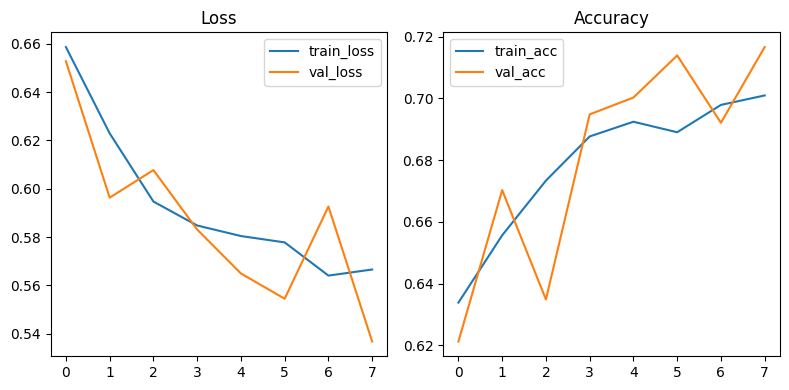

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc'); plt.plot(history.history['val_accuracy'], label='val_acc'); plt.legend(); plt.title("Accuracy")
plt.tight_layout()
plt.show()